In [1]:
# Standard library imports
import csv
import os
import pickle
from collections import Counter
from itertools import combinations
import math
from math import sqrt
import time

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import imageio

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Local imports
from utils import *

import warnings
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create 'images' or 'data' directory if it doesn't exist
if not os.path.exists("images"):
    os.mkdir("images")
if not os.path.exists("data"):
    os.mkdir("data")

Load the corrected data set from the CSV

In [2]:
speech = pd.read_csv('data/outliercorrected_pd_speech_features.csv',header=[0,1],index_col=0)
display(speech)

# make a list of columns that contain all features, that are not patient id, class and gender
column_list = list(speech.columns)
feature_columns  = column_list.copy()
feature_columns.remove(('Info','class'))
feature_columns.remove(('Info','gender'))
display(feature_columns)

Info Baseline Features                                                   \
    gender               PPE       DFA      RPDE   numPulses numPeriodsPulses   
ID                                                                              
0      1.0          0.823387  0.696370  0.567250  235.333333       234.333333   
1      0.0          0.418480  0.793993  0.592453  213.333333       211.000000   
2      1.0          0.801973  0.619967  0.520563  319.333333       318.333333   
3      0.0          0.828707  0.626097  0.537183  493.000000       492.000000   
4      0.0          0.831287  0.779397  0.726717  362.666667       361.666667   
..     ...               ...       ...       ...         ...              ...   
247    0.0          0.751703  0.651830  0.586847  326.000000       324.666667   
248    1.0          0.611750  0.688327  0.452343  356.666667       355.333333   
249    1.0          0.819857  0.788800  0.373520  339.666667       338.666667   
250    0.0          0.600530  0.569010  0.411987  402.333333       401.000000   
251    0.0          0.844917  0.745653  0.476707  353.666667       352.666667   

                                                                   ...  \
    meanPeriodPulses stdDevPeriodPulses locPctJitter locAbsJitter  ...   
ID                                                                 ...   
0           0.008220           0.000073     0.001963     0.000016  ...   
1           0.008884           0.001849     0.005790     0.000050  ...   
2           0.006041           0.000104     0.002217     0.000013  ...   
3           0.003913           0.000042     0.000757     0.000003  ...   
4           0.005622           0.002023     0.003593     0.000021  ...   
..               ...                ...          ...          ...  ...   
247         0.005911           0.000251     0.003193     0.000019  ...   
248         0.005410           0.000964     0.002467     0.000014  ...   
249         0.005684           0.000042     0.000800     0.000005  ...   
250         0.004775           0.000103     0.000983     0.000005  ...   
251         0.005475           0.000065     0.000820     0.000005  ...   

                TQWT Features                            \
    tqwt_kurtosisValue_dec_28 tqwt_kurtosisValue_dec_29   
ID                                                        
0                    1.561733                  2.862000   
1                    4.918567                  4.827133   
2                   41.129400                 31.201933   
3                    1.677633                  1.908400   
4                    4.104600                  4.285233   
..                        ...                       ...   
247                 19.298667                 15.072200   
248                  4.448533                  3.180933   
249                 90.482767                 65.641367   
250                  2.674667                  2.714200   
251                 44.571367                 26.370167   

                                                         \
    tqwt_kurtosisValue_dec_30 tqwt_kurtosisValue_dec_31   
ID                                                        
0                   12.293333                  9.717500   
1                    6.117633                  8.599667   
2                   14.584467                  5.446800   
3                    2.842167                  3.493867   
4                    2.953200                  2.799933   
..                        ...                       ...   
247                 13.479700                 14.877933   
248                  2.880233                  2.805067   
249                 29.098533                  8.966500   
250                  2.706000                  2.637700   
251                 14.782567                  4.455833   

                                                         \
    tqwt_kurtosisValue_dec_32 tqwt_kurtosisValue_dec_33   
ID                                                        
0  

[('Baseline Features', 'PPE'),
 ('Baseline Features', 'DFA'),
 ('Baseline Features', 'RPDE'),
 ('Baseline Features', 'numPulses'),
 ('Baseline Features', 'numPeriodsPulses'),
 ('Baseline Features', 'meanPeriodPulses'),
 ('Baseline Features', 'stdDevPeriodPulses'),
 ('Baseline Features', 'locPctJitter'),
 ('Baseline Features', 'locAbsJitter'),
 ('Baseline Features', 'rapJitter'),
 ('Baseline Features', 'ppq5Jitter'),
 ('Baseline Features', 'ddpJitter'),
 ('Baseline Features', 'locShimmer'),
 ('Baseline Features', 'locDbShimmer'),
 ('Baseline Features', 'apq3Shimmer'),
 ('Baseline Features', 'apq5Shimmer'),
 ('Baseline Features', 'apq11Shimmer'),
 ('Baseline Features', 'ddaShimmer'),
 ('Baseline Features', 'meanAutoCorrHarmonicity'),
 ('Baseline Features', 'meanNoiseToHarmHarmonicity'),
 ('Baseline Features', 'meanHarmToNoiseHarmonicity'),
 ('Intensity Parameters', 'minIntensity'),
 ('Intensity Parameters', 'maxIntensity'),
 ('Intensity Parameters', 'meanIntensity'),
 ('Formant Frequenci

Splitting the Dataset into Training and Test Sets

In [3]:
gender = speech[('Info','gender')]
y = speech[('Info','class')]

X_train_val, X_test, y_train_val, y_test, gender_train, gender_test = train_test_split(
    speech[feature_columns], y, gender, test_size=0.2, random_state=42)

In [4]:
# Perform PCA (Principal Component Analysis) to reduce the data to 3 components
pca = PCA(n_components=3)
sc = StandardScaler()
scaled_data = sc.fit_transform(speech[feature_columns])
pca_result = pca.fit_transform(scaled_data)
# Save percantage explained per PCA for later plottting
percantage_explained = pca.explained_variance_ratio_

# Create a new DataFrame for the PCA results with 3 principal components
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

pca_df['set'] = 'train'
pca_df.loc[X_test.index, 'set'] = 'test'
 
fig = px.scatter_3d(
    pca_df, x='PC1', y='PC2', z='PC3', 
    title="3D PCA",
    labels={
        'PC1': f'PC1 ({percantage_explained[0]*100:.2f}%)',
        'PC2': f'PC2 ({percantage_explained[1]*100:.2f}%)',
        'PC3': f'PC3 ({percantage_explained[2]*100:.2f}%)'
    },
    color=pca_df['set'],
    symbol=speech[('Info','gender')].values
)
# Update marker properties
fig.update_traces(marker=dict(size=5,
                              line=dict(width=2)),
                  selector=dict(mode='markers'))

# Display the 3D scatter plot and save it as png
fig.show()

fig.write_image("images/PCA train test.png")

# Create frames for the rotation
frames = []
for angle in tqdm(range(0, 360, 5)):  # 5 degree steps
    camera = dict(
        eye=dict(x=np.cos(np.radians(angle))* 1.5, y=np.sin(np.radians(angle))* 1.5, z=0.5),
        center=dict(x=0, y=0, z=0)
    )
    fig.update_layout(scene_camera=camera)
    img_bytes = fig.to_image(format="png")
    frames.append(imageio.imread(img_bytes))

# Save the frames as a gif
imageio.mimsave('images/pca_3d_rotation.gif', frames, fps=15)

print("GIF saved as 'pca_3d_rotation.gif'")

fig = px.scatter(
    pca_df, x='PC1', y='PC2', 
    color=pca_df['set'], 
    title="Train Test Split PCA",
    labels={
        'PC1': f'PC1 ({percantage_explained[0]*100:.2f}%)',
        'PC2': f'PC2 ({percantage_explained[1]*100:.2f}%)'
    }
)
fig.show()

  0%|          | 0/72 [00:00<?, ?it/s]

C:\Users\bradn\AppData\Local\Temp\ipykernel_53280\4255750620.py:45: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



GIF saved as 'pca_3d_rotation.gif'


Applying Jackknife Resampling to the Training Data for Model Robustness

In [5]:
# Define the filename for the top features
TOP_FEATURES_FILE = 'data/top_features.pkl'

# Define an amount of features to find
n_features_to_find = int(sqrt(len(feature_columns)))

# Check if the file with top features already exists
if os.path.exists(TOP_FEATURES_FILE):
    print(f"Loading top features from {TOP_FEATURES_FILE}")
    # If it exists, load the top features from the file
    with open(TOP_FEATURES_FILE, 'rb') as f:
        top_features = pickle.load(f)
else:
    print(f"File {TOP_FEATURES_FILE} not found. Running feature selection process...")
    
    # Define a list of random seeds for reproducibility
    seed_list = range(1,101)
    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()
    
    # Iterate through each random seed
    for random_state in tqdm(seed_list):
        print(random_state)
        # Split the data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=random_state)
        speech_temp = X_train_val.copy()
        # Perform feature selection and evaluation
        result_df = feature_selection_and_evaluation(X_train, X_val, y_train, y_val, n_features_to_find, 1000)
        result_df['random state'] = random_state
        # Append results to the main DataFrame
        results_df = pd.concat([results_df, result_df], axis=0)

    # Count the frequency of each selected feature across all iterations
    feature_counts = Counter()
    for feature in results_df['Selected Features'].values:
        feature_counts.update(feature)
    
    # Select the top sqrt(n) features based on their frequency
    top_features = [feature for feature, count in feature_counts.most_common(n_features_to_find)]
    
    # Save the top features to a file using pickle
    # would save this as a csv but the column names need to be saved as tuples and reading that in from csv is more work.
    with open(TOP_FEATURES_FILE, 'wb') as f:
        pickle.dump(top_features, f)
    
    print(f"Top features saved to {TOP_FEATURES_FILE}")

# Display the top features
print("Top features:")
display(top_features)

File data/top_features.pkl not found. Running feature selection process...


  0%|          | 0/100 [00:00<?, ?it/s]

1
Selected features: [('Formant Frequencies', 'f1'), ('MFCC ', 'mean_MFCC_2nd_coef'), ('MFCC ', 'std_8th_delta_delta'), ('TQWT Features', 'tqwt_entropy_shannon_dec_12'), ('TQWT Features', 'tqwt_entropy_shannon_dec_13'), ('TQWT Features', 'tqwt_entropy_shannon_dec_15'), ('TQWT Features', 'tqwt_TKEO_mean_dec_12'), ('TQWT Features', 'tqwt_TKEO_mean_dec_16'), ('TQWT Features', 'tqwt_TKEO_std_dec_12'), ('TQWT Features', 'tqwt_TKEO_std_dec_13'), ('TQWT Features', 'tqwt_stdValue_dec_12'), ('TQWT Features', 'tqwt_stdValue_dec_13'), ('TQWT Features', 'tqwt_minValue_dec_12'), ('TQWT Features', 'tqwt_minValue_dec_13'), ('TQWT Features', 'tqwt_maxValue_dec_12'), ('TQWT Features', 'tqwt_maxValue_dec_13'), ('TQWT Features', 'tqwt_kurtosisValue_dec_26'), ('TQWT Features', 'tqwt_kurtosisValue_dec_27'), ('MFCC ', 'std_8th_delta'), ('TQWT Features', 'tqwt_entropy_shannon_dec_16'), ('TQWT Features', 'tqwt_stdValue_dec_15'), ('TQWT Features', 'tqwt_stdValue_dec_16'), ('TQWT Features', 'tqwt_maxValue_dec_1

[('MFCC ', 'std_8th_delta_delta'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_27'),
 ('MFCC ', 'std_8th_delta'),
 ('MFCC ', 'mean_MFCC_2nd_coef'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_26'),
 ('MFCC ', 'std_9th_delta_delta'),
 ('MFCC ', 'std_7th_delta_delta'),
 ('MFCC ', 'std_6th_delta_delta'),
 ('MFCC ', 'std_9th_delta'),
 ('MFCC ', 'std_6th_delta'),
 ('MFCC ', 'std_7th_delta'),
 ('TQWT Features', 'tqwt_minValue_dec_12'),
 ('MFCC ', 'std_11th_delta_delta'),
 ('TQWT Features', 'tqwt_stdValue_dec_12'),
 ('TQWT Features', 'tqwt_maxValue_dec_12'),
 ('MFCC ', 'std_delta_delta_log_energy'),
 ('MFCC ', 'std_11th_delta'),
 ('MFCC ', 'std_10th_delta_delta'),
 ('TQWT Features', 'tqwt_maxValue_dec_11'),
 ('TQWT Features', 'tqwt_stdValue_dec_11'),
 ('TQWT Features', 'tqwt_entropy_log_dec_12'),
 ('TQWT Features', 'tqwt_minValue_dec_13'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_28'),
 ('MFCC ', 'std_10th_delta'),
 ('TQWT Features', 'tqwt_entropy_shannon_dec_15'),
 ('MFCC ', 'std_12th_delta_

ANOVA Analysis of Features by Gender and Parkinson's Disease Status

ANOVA Results:


,Feature,Gender,F-value,p-value
6,"('MFCC ', 'mean_MFCC_2nd_coef')",Female,41.742694,5.037170e-09
4,"('MFCC ', 'std_8th_delta')",Female,29.472149,4.673059e-07
2,"('TQWT Features', 'tqwt_kurtosisValue_dec_27')",Female,28.202495,7.685301e-07
0,"('MFCC ', 'std_8th_delta_delta')",Female,27.797930,9.016763e-07
38,"('TQWT Features', 'tqwt_stdValue_dec_11')",Female,26.498944,1.512412e-06
48,"('TQWT Features', 'tqwt_entropy_shannon_dec_15')",Female,25.605033,2.167174e-06
8,"('TQWT Features', 'tqwt_kurtosisValue_dec_26')",Female,25.395662,2.358755e-06
36,"('TQWT Features', 'tqwt_maxValue_dec_11')",Female,25.376471,2.377162e-06
22,"('TQWT Features', 'tqwt_minValue_dec_12')",Female,23.958666,4.238964e-06
34,"('MFCC ', 'std_10th_delta_delta')",Female,23.695627,4.723451e-06


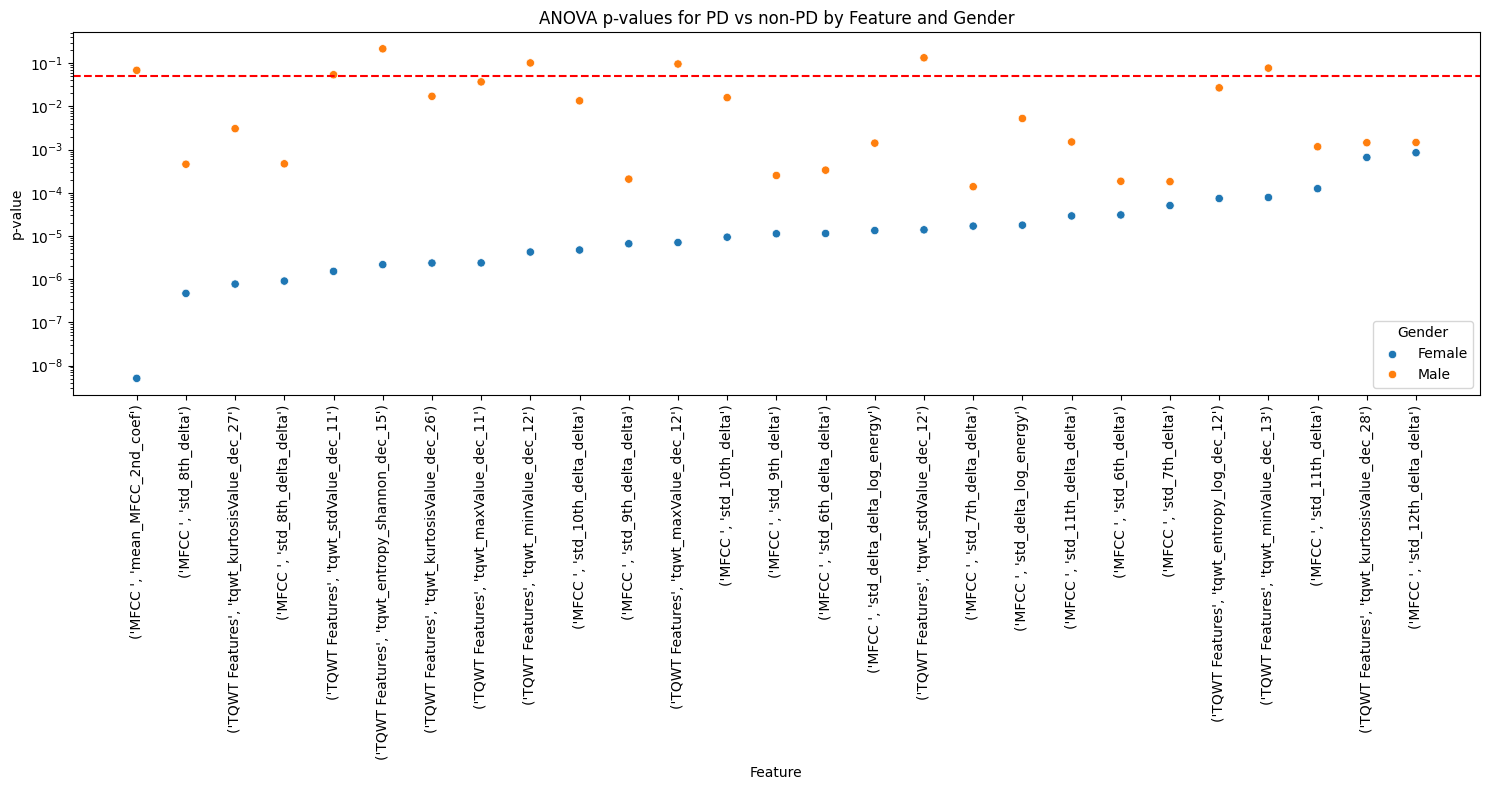

In [6]:
# Combine training and validation data with labels and gender information
combined_df = pd.concat([X_train_val, y_train_val, gender_train], axis=1)

# Perform ANOVA analysis
anova_results = perform_anova(combined_df, top_features, 
                              pd_column=('Info','class'), 
                              gender_column=('Info','gender'))

# Convert Feature column to string type for proper display
anova_results['Feature'] = anova_results['Feature'].astype(str)

# Sort results by p-value
anova_results = anova_results.sort_values('p-value')

# Display ANOVA results
print("ANOVA Results:")
display(anova_results)

# Visualize ANOVA results
plt.figure(figsize=(15, 8))
sns.scatterplot(x='Feature', y='p-value', hue='Gender', data=anova_results)
plt.yscale('log')  # Use log scale for p-values
plt.axhline(y=0.05, color='r', linestyle='--')  # Add significance threshold line
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('ANOVA p-values for PD vs non-PD by Feature and Gender')
plt.tight_layout()
plt.show()

Visualizing Feature Distributions by Parkinson's Disease Status and Gender


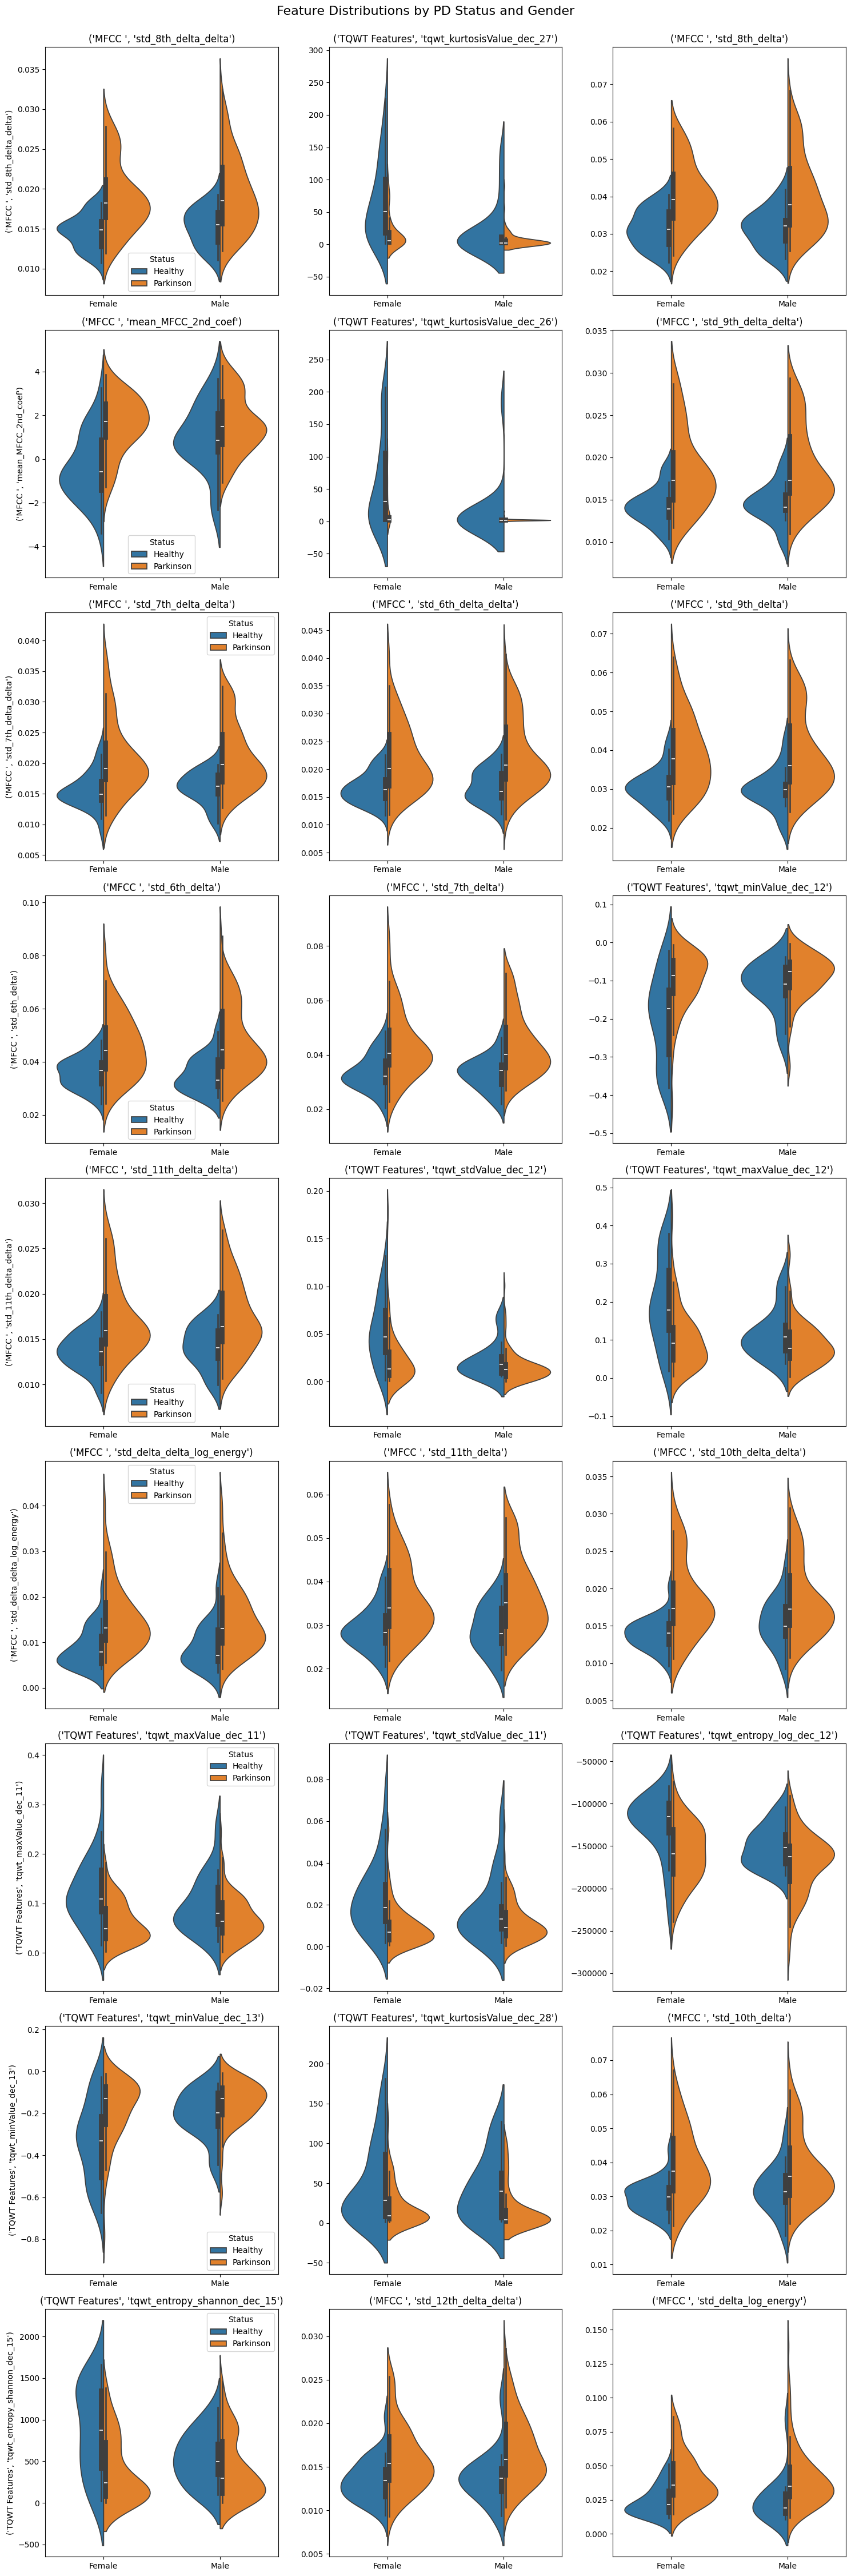

In [7]:
plot_feature_distributions(combined_df, top_features, pd_column=('Info','class'), gender_column=('Info','gender'), anova_results=anova_results)

Analyzing Significant Features by Gender

In [8]:
# Filter for significant features (p-value < 0.05)
test = anova_results[anova_results['p-value'] < 0.05]

# Initialize list to store new DataFrame rows
new_df_list = []

# Iterate through unique features in the filtered results
for feature in test['Feature'].unique():
    feature_data = test[test['Feature'] == feature]
    
    # Check if we have data for both genders
    if len(feature_data) == 2:
        male_data = feature_data[feature_data['Gender'] == 'Male']
        female_data = feature_data[feature_data['Gender'] == 'Female']
        
        # Create a new row with male and female data side by side
        new_row = {
            'Feature': feature,
            'F-value_Male': male_data['F-value'].values[0],
            'F-value_Female': female_data['F-value'].values[0],
            'p-value_Male': male_data['p-value'].values[0],
            'p-value_Female': female_data['p-value'].values[0]
        }
        
        new_df_list.append(new_row)

# Create the new DataFrame from the list of dictionaries
new_df = pd.DataFrame(new_df_list)

# Set 'Feature' as the index
new_df.set_index('Feature', inplace=True)

# Display the new DataFrame
display(new_df)

,F-value_Male,F-value_Female,p-value_Male,p-value_Female
Feature,,,,
"('MFCC ', 'std_8th_delta')",13.085921,29.472149,0.000457,4.673059e-07
"('TQWT Features', 'tqwt_kurtosisValue_dec_27')",9.194720,28.202495,0.003052,7.685301e-07
"('MFCC ', 'std_8th_delta_delta')",13.037480,27.797930,0.000468,9.016763e-07
"('TQWT Features', 'tqwt_kurtosisValue_dec_26')",5.871126,25.395662,0.017086,2.358755e-06
"('TQWT Features', 'tqwt_maxValue_dec_11')",4.466858,25.376471,0.036905,2.377162e-06
"('MFCC ', 'std_10th_delta_delta')",6.319587,23.695627,0.013445,4.723451e-06
"('MFCC ', 'std_9th_delta_delta')",14.775182,22.889262,0.000207,6.593720e-06
"('MFCC ', 'std_10th_delta')",5.999856,22.049553,0.015946,9.360148e-06
"('MFCC ', 'std_9th_delta')",14.359813,21.611743,0.000251,1.124982e-05


Optimizing Random Forest Hyperparameters with Cross-Validation


In [9]:
start_time = time.perf_counter()
# Define parameter grid
param_grid = {
    'n_estimators': list(range(100,1600,100)),
    'max_depth': [10, 20, 30, None]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, 
                           scoring='f1_weighted', n_jobs=-1, verbose=5)
grid_search.fit(X_train_val[top_features], y_train_val, groups=gender_train)

# Get best parameters
best_params_rf = grid_search.best_params_
print(f"Best parameters: {best_params_rf}")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'max_depth': 10, 'n_estimators': 400}
Execution time: 174.883835 seconds


Evaluating Random Forest Performance with ROC and Precision-Recall Curves


Overall accuracy: 0.843


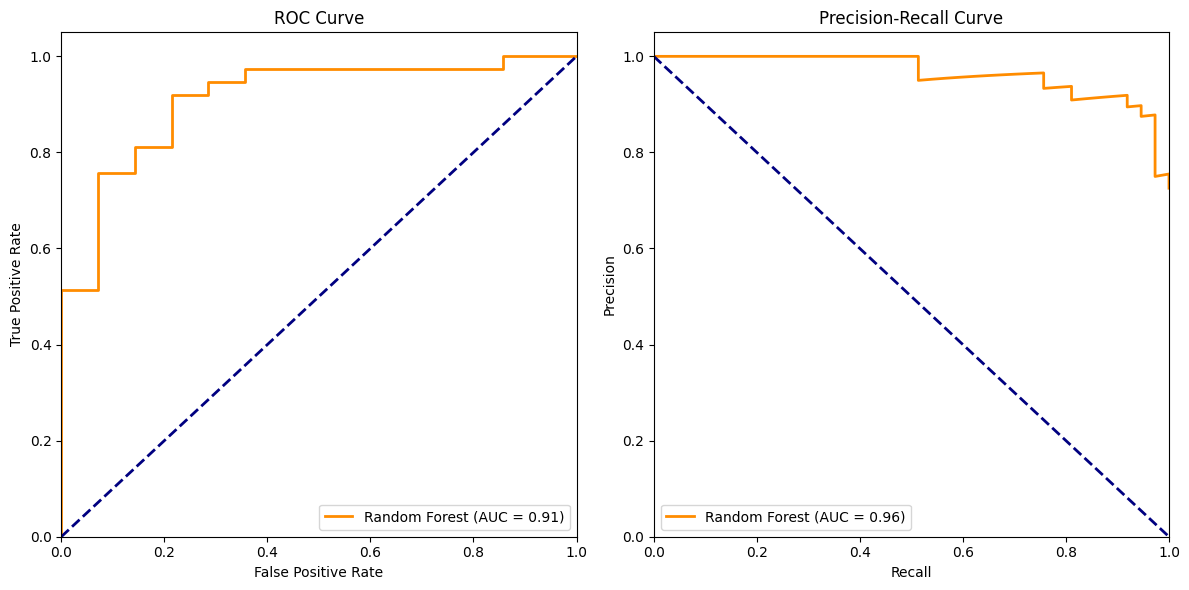

Accuracy: 0.843
              precision    recall  f1-score   support

     Healthy       0.88      0.50      0.64        14
          PD       0.84      0.97      0.90        37

    accuracy                           0.84        51
   macro avg       0.86      0.74      0.77        51
weighted avg       0.85      0.84      0.83        51



In [11]:
# Initialize Random Forest with best parameters found from grid search
rf = RandomForestClassifier(max_depth=best_params_rf['max_depth'],
                            n_estimators=best_params_rf['n_estimators'],
                            random_state=42, n_jobs=-1)

# Fit the model on the training data using only top features
rf.fit(X_train_val[top_features], y_train_val)

# Make predictions on the test set
y_pred = rf.predict(X_test[top_features])
print(f"Overall accuracy: {accuracy_score(y_test, y_pred):.3f}")

# Get probability predictions
y_pred_proba = rf.predict_proba(X_test[top_features])

# Calculate ROC AUC score
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
auc_pr = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(122)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Print detailed classification report
report = classification_report(y_test, y_pred, target_names=['Healthy', 'PD'], output_dict=True)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'PD']))


Feature Set Evaluation Using ANOVA and Random Forest

  0%|          | 0/254 [00:00<?, ?it/s]


Top results:


,Feature_Sets,Amount_of_Features,AUC_ROC,AUC_PR
0,Intensity Parameters - MFCC - TQWT Features,519,0.959459,0.986094
1,Baseline Features - MFCC - TQWT Features,537,0.961390,0.985176
2,Vocal Fold - MFCC - TQWT Features,538,0.951737,0.983135
3,Baseline Features - Intensity Parameters - MFC...,540,0.951737,0.981943
4,Intensity Parameters - Formant Frequencies - V...,545,0.947876,0.981866
...,...,...,...,...
57,Intensity Parameters - MFCC - Wavelet Feature...,701,0.920849,0.964736
58,Baseline Features - Intensity Parameters - Ban...,294,0.909266,0.964697
59,Intensity Parameters - Formant Frequencies - V...,461,0.907336,0.964420
60,Baseline Features - Intensity Parameters - Ban...,134,0.907336,0.964416


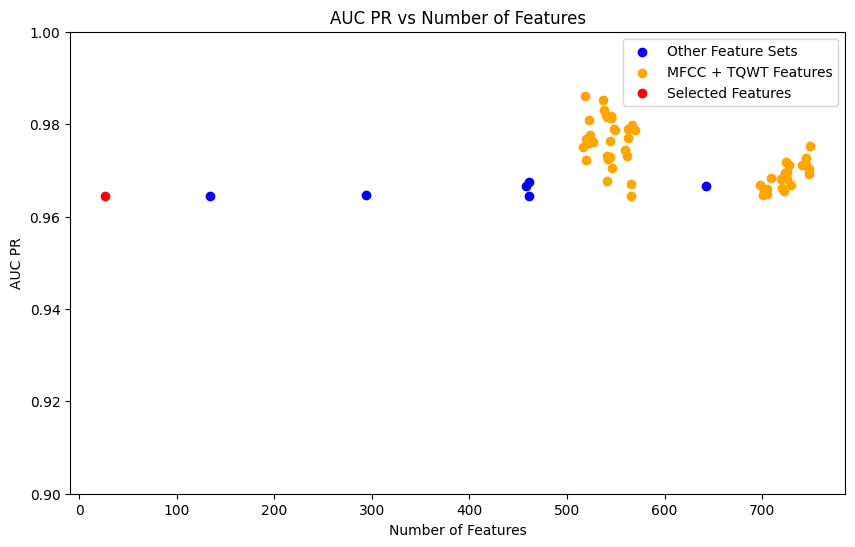

In [13]:
# Define the filename for storing ANOVA results
ANOVA_FILE = 'data/AUC_feature_sets.pkl'

# Check if the file exists and load it if it does
if os.path.exists(ANOVA_FILE):
    print(f"Loading AUC DF from {ANOVA_FILE}")
    with open(ANOVA_FILE, 'rb') as f:
        results_df = pickle.load(f)
else:
    # Get unique feature sets
    list_featuresets = list(pd.unique(speech.columns.get_level_values(0)))
    list_featuresets.remove('Info')
    
    # Generate all possible combinations of feature sets
    combination_list = [combo for i in range(len(list_featuresets)) 
                        for combo in combinations(list_featuresets, i) if combo]

    # Initialize results DataFrame
    results_df = pd.DataFrame(columns=['Feature_Sets', 'Amount_of_Features', 'AUC_ROC', 'AUC_PR'])

    # Evaluate each feature set combination
    for feature_sets in tqdm(combination_list, leave=False):
        rf_baseline = RandomForestClassifier(max_depth=best_params_rf['max_depth'],
                            n_estimators=best_params_rf['n_estimators'],
                            random_state=42, n_jobs=-1)
        selected_columns = X_train_val.columns[X_train_val.columns.get_level_values(0).isin(feature_sets)]
        selected_columns = selected_columns.values
        rf_baseline.fit(X_train_val[selected_columns], y_train_val)
        y_pred_proba = rf_baseline.predict_proba(X_test[selected_columns])

        # Calculate performance metrics
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
        auc_pr_test = auc(recall, precision)

        if auc_pr_test > auc_pr:  # This condition might need explanation or revision
            # Add results to the DataFrame
            new_row = pd.DataFrame({
                'Feature_Sets': [' - '.join(feature_sets)],
                'Amount_of_Features': [len(selected_columns)],
                'AUC_ROC': [auc_roc],
                'AUC_PR': [auc_pr_test]
            })
            results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Sort results and save
    results_df = results_df.sort_values('AUC_PR', ascending=False).reset_index(drop=True)
    with open(ANOVA_FILE, 'wb') as f:
        pickle.dump(results_df, f)

# Display results
print("\nTop results:")
display(results_df)

# Plot results
plt.figure(figsize=(10, 6))

# Create a boolean mask for points that contain both 'MFCC' and 'TQWT Features' as per paper results
mask = results_df['Feature_Sets'].str.contains('MFCC') & results_df['Feature_Sets'].str.contains('TQWT Features')

# Plot points that don't meet the condition in blue
plt.scatter(results_df.loc[~mask, 'Amount_of_Features'], 
            results_df.loc[~mask, 'AUC_PR'], 
            label='Other Feature Sets', 
            color='blue')

# Plot points that meet the condition in orange
plt.scatter(results_df.loc[mask, 'Amount_of_Features'], 
            results_df.loc[mask, 'AUC_PR'], 
            label='MFCC + TQWT Features', 
            color='orange')

# Plot the selected features point in red
plt.scatter(n_features_to_find, auc_pr, color='red', label='Selected Features')

plt.ylim([0.9, 1])
plt.xlabel('Number of Features')
plt.ylabel('AUC PR')
plt.title('AUC PR vs Number of Features')
plt.legend()
plt.show()

Gender-Specific Performance Analysis and Feature Importance Evaluation


Female Performance:
Accuracy: 0.862

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.86      0.67      0.75         9
          PD       0.86      0.95      0.90        20

    accuracy                           0.86        29
   macro avg       0.86      0.81      0.83        29
weighted avg       0.86      0.86      0.86        29


Male Performance:
Accuracy: 0.818

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.20      0.33         5
          PD       0.81      1.00      0.89        17

    accuracy                           0.82        22
   macro avg       0.90      0.60      0.61        22
weighted avg       0.85      0.82      0.77        22



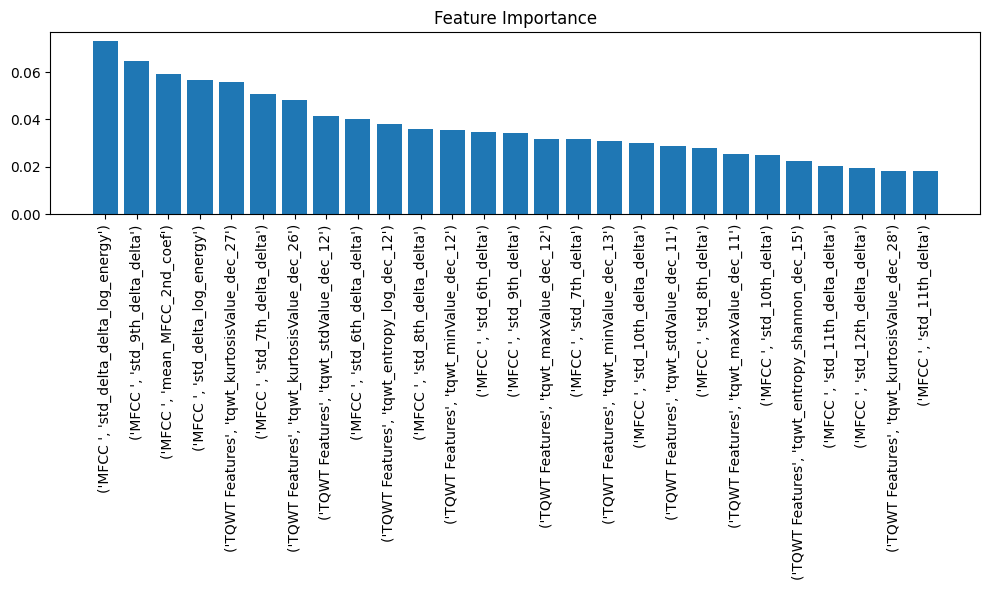

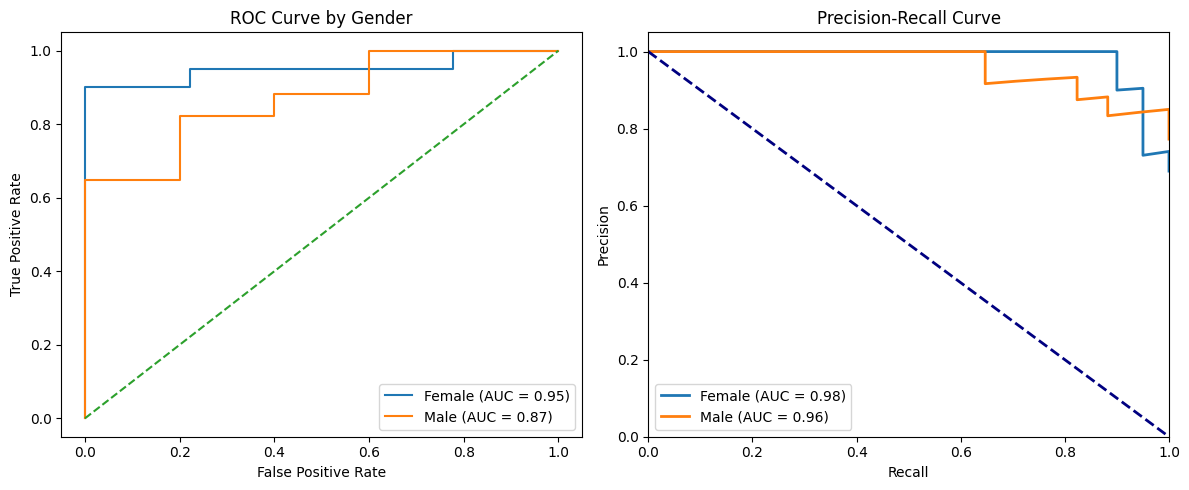

,feature removed,auc_roc,gender
0,"(MFCC , std_8th_delta_delta)",0.843137,all
1,"(TQWT Features, tqwt_kurtosisValue_dec_27)",0.843137,all
2,"(MFCC , std_8th_delta)",0.862745,all
3,"(MFCC , mean_MFCC_2nd_coef)",0.823529,all
4,"(TQWT Features, tqwt_kurtosisValue_dec_26)",0.843137,all
...,...,...,...
76,"(TQWT Features, tqwt_kurtosisValue_dec_28)",0.818182,Male
77,"(MFCC , std_10th_delta)",0.818182,Male
78,"(TQWT Features, tqwt_entropy_shannon_dec_15)",0.818182,Male
79,"(MFCC , std_12th_delta_delta)",0.818182,Male


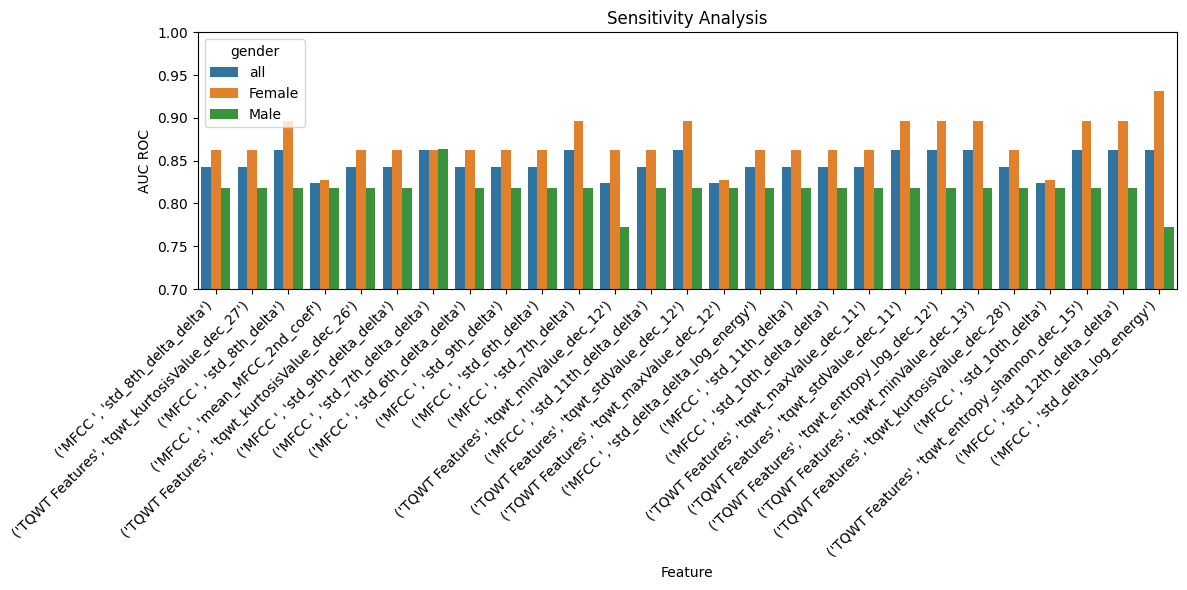

In [14]:
# Prepare test data with top features
X_test_top_features = X_test[top_features].copy()

# Gender-specific performance analysis
for gender_label in [0, 1]:
    gender = 'Female' if gender_label == 0 else 'Male'
    gender_mask = (gender_test == gender_label)
    y_gender = y_test[gender_mask]
    X_gender = X_test_top_features[gender_mask]
    y_pred_gender = rf.predict(X_gender)
    
    print(f"\n{gender} Performance:")
    print(f"Accuracy: {accuracy_score(y_gender, y_pred_gender):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_gender, y_pred_gender, target_names=['Healthy', 'PD']))

# Feature importance visualization
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'feature': top_features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'].astype(str), feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Sensitivity analysis
gender_df = pd.DataFrame(columns=['feature removed', 'auc_roc', 'gender'])

for gender_label in [None, 0, 1]:
    if gender_label is None:
        gender = 'all'
        X_test_subset = X_test_top_features
        y_test_subset = y_test
    else:
        gender = 'Female' if gender_label == 0 else 'Male'
        gender_mask = (gender_test == gender_label)
        X_test_subset = X_test_top_features[gender_mask]
        y_test_subset = y_test[gender_mask]
    
    for feature in top_features:
        X_test_mod = X_test_subset.copy()
        X_test_mod.iloc[:, top_features.index(feature)] = 0  # Set feature to 0
        y_pred_mod = rf.predict(X_test_mod)
        auc_roc = accuracy_score(y_test_subset, y_pred_mod)
        new_row = pd.DataFrame([{'feature removed': feature, 
                                 'auc_roc': auc_roc,
                                 'gender': gender}])
        gender_df = pd.concat([gender_df, new_row], ignore_index=True)

# ROC and Precision-Recall curves for each gender
plt.figure(figsize=(12, 5))
for gender_label in [0, 1]:
    gender = 'Female' if gender_label == 0 else 'Male'
    gender_mask = (gender_test == gender_label)
    y_gender = y_test[gender_mask]
    X_gender = X_test_top_features[gender_mask]
    y_pred_proba = rf.predict_proba(X_gender)[:, 1]
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_gender, y_pred_proba)
    auc_roc = roc_auc_score(y_gender, y_pred_proba)
    plt.subplot(121)
    plt.plot(fpr, tpr, label=f'{gender} (AUC = {auc_roc:.2f})')
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_gender, y_pred_proba)
    auc_prc = auc(recall, precision)
    plt.subplot(122)
    plt.plot(recall, precision, lw=2, label=f'{gender} (AUC = {auc_prc:.2f})')

# Finalize ROC plot
plt.subplot(121)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Gender')
plt.legend()

# Finalize Precision-Recall plot
plt.subplot(122)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Display sensitivity analysis results
display(gender_df)

# Visualize sensitivity analysis
gender_df['feature removed'] = gender_df['feature removed'].astype(str)
plt.figure(figsize=(12, 6))
sns.barplot(x='feature removed', y='auc_roc', hue='gender', data=gender_df)
plt.title('Sensitivity Analysis')
plt.xlabel('Feature')
plt.ylabel('AUC ROC')
lower_limit = math.floor(gender_df['auc_roc'].min() * 10) / 10
plt.ylim([lower_limit, 1])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Training and Evaluating a Random Forest Model with Significant Features


Overall accuracy: 0.804


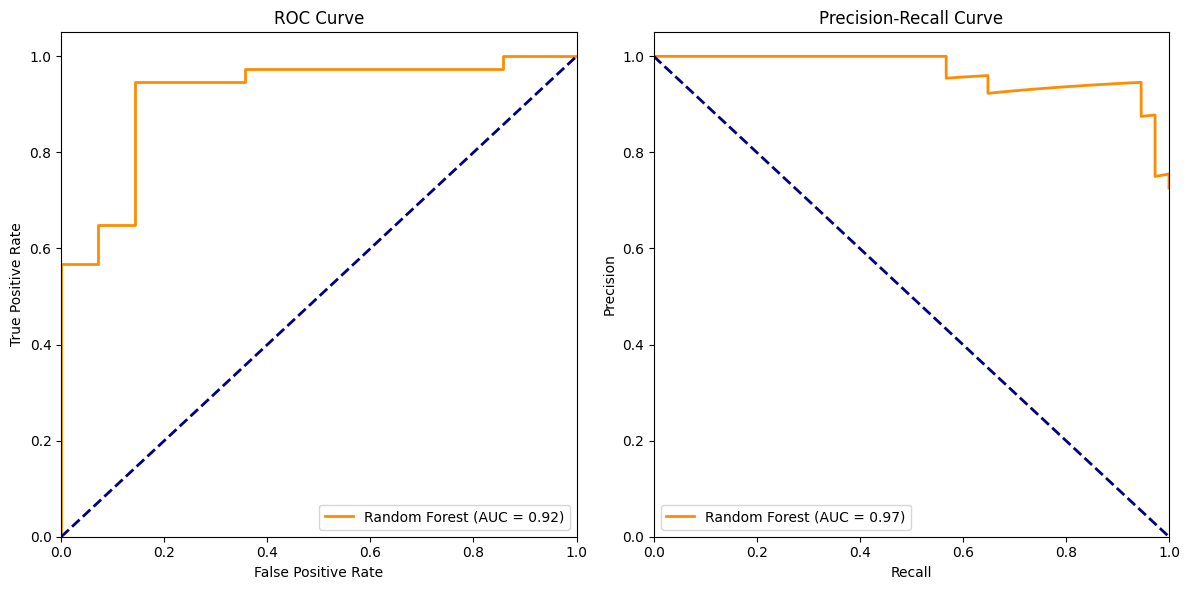

In [15]:
# Convert string representations of features back to their original form
feature_list = [eval(item) for item in new_df.index.values]

# Initialize Random Forest classifier with best parameters from previous grid search
rf_small = RandomForestClassifier(max_depth=best_params_rf['max_depth'],
                                  n_estimators=best_params_rf['n_estimators'],
                                  random_state=42, n_jobs=-1)

# Fit the model on training data using only the selected features
rf_small.fit(X_train_val[feature_list], y_train_val)

# Make predictions on test set
y_pred = rf_small.predict(X_test[feature_list])
print(f"Overall accuracy: {accuracy_score(y_test, y_pred):.3f}")

# Get probability predictions
y_pred_proba = rf_small.predict_proba(X_test[feature_list])

# Calculate ROC AUC score
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
auc_pr = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(122)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

Gender-Specific Performance Analysis and Feature Importance Evaluation with Significant Features


Female Performance:
Accuracy: 0.793

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.80      0.44      0.57         9
          PD       0.79      0.95      0.86        20

    accuracy                           0.79        29
   macro avg       0.80      0.70      0.72        29
weighted avg       0.79      0.79      0.77        29


Male Performance:
Accuracy: 0.818

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.20      0.33         5
          PD       0.81      1.00      0.89        17

    accuracy                           0.82        22
   macro avg       0.90      0.60      0.61        22
weighted avg       0.85      0.82      0.77        22



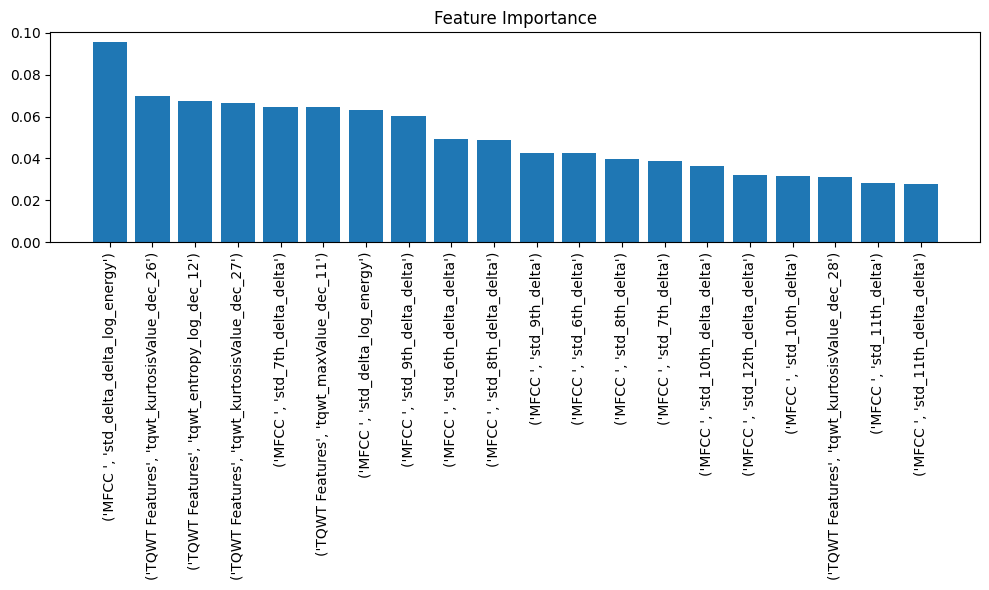

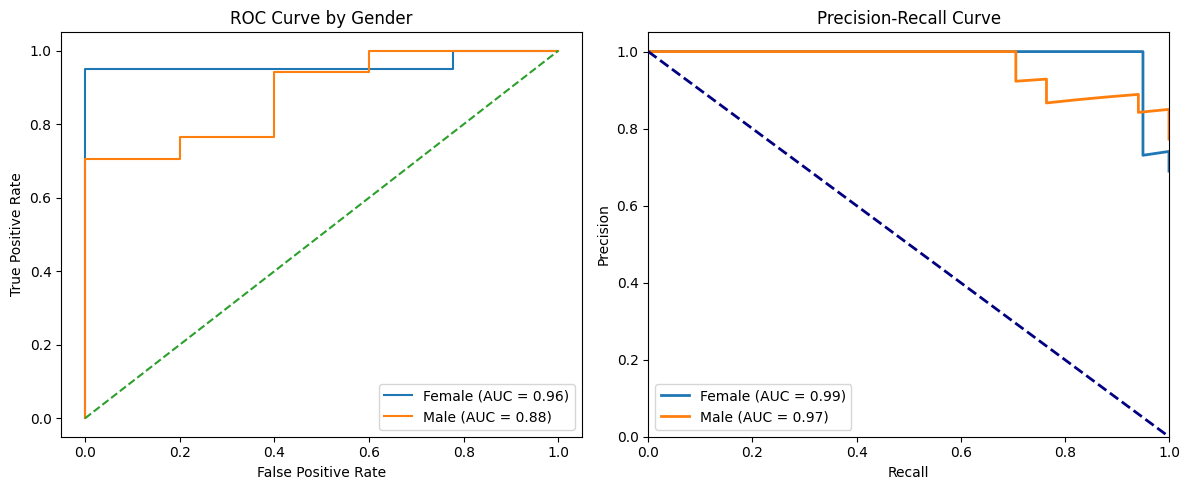

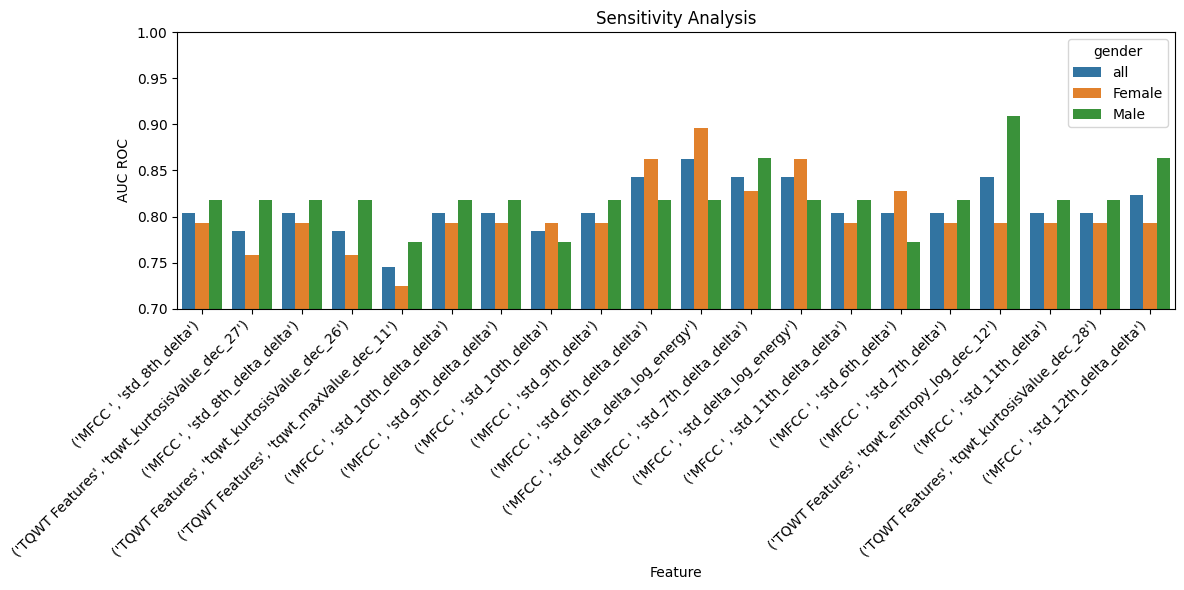

In [16]:
X_test_small = X_test[feature_list].copy()

# Gender-specific performance analysis
for gender_label in [0, 1]:
    gender = 'Female' if gender_label == 0 else 'Male'
    gender_mask = (gender_test == gender_label)
    y_gender = y_test[gender_mask]
    X_gender = X_test_small[gender_mask]
    y_pred_gender = rf_small.predict(X_gender)
    
    print(f"\n{gender} Performance:")
    print(f"Accuracy: {accuracy_score(y_gender, y_pred_gender):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_gender, y_pred_gender, target_names=['Healthy', 'PD']))

# Feature importance visualization
importances = rf_small.feature_importances_
feature_importance = pd.DataFrame({'feature': feature_list, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'].astype(str), feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Sensitivity analysis
gender_df = pd.DataFrame(columns=['feature removed', 'auc_roc', 'gender'])

for gender_label in [None, 0, 1]:
    if gender_label is None:
        gender = 'all'
        X_test_subset = X_test_small
        y_test_subset = y_test
    else:
        gender = 'Female' if gender_label == 0 else 'Male'
        gender_mask = (gender_test == gender_label)
        X_test_subset = X_test_small[gender_mask]
        y_test_subset = y_test[gender_mask]
    
    for feature in feature_list:
        X_test_mod = X_test_subset.copy()
        X_test_mod.iloc[:, feature_list.index(feature)] = 0  # Set feature to 0
        y_pred_mod = rf_small.predict(X_test_mod)
        auc_roc = accuracy_score(y_test_subset, y_pred_mod)
        new_row = pd.DataFrame([{'feature removed': feature, 
                                 'auc_roc': auc_roc,
                                 'gender': gender}])
        gender_df = pd.concat([gender_df, new_row], ignore_index=True)

# ROC and Precision-Recall curves for each gender
plt.figure(figsize=(12, 5))
for gender_label in [0, 1]:
    gender = 'Female' if gender_label == 0 else 'Male'
    gender_mask = (gender_test == gender_label)
    y_gender = y_test[gender_mask]
    X_gender = X_test_small[gender_mask]
    y_pred_proba = rf_small.predict_proba(X_gender)[:, 1]
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_gender, y_pred_proba)
    auc_roc = roc_auc_score(y_gender, y_pred_proba)
    plt.subplot(121)
    plt.plot(fpr, tpr, label=f'{gender} (AUC = {auc_roc:.2f})')
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_gender, y_pred_proba)
    auc_prc = auc(recall, precision)
    plt.subplot(122)
    plt.plot(recall, precision, lw=2, label=f'{gender} (AUC = {auc_prc:.2f})')

# Finalize ROC plot
plt.subplot(121)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Gender')
plt.legend()

# Finalize Precision-Recall plot
plt.subplot(122)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Visualize sensitivity analysis
gender_df['feature removed'] = gender_df['feature removed'].astype(str)
plt.figure(figsize=(12, 6))
sns.barplot(x='feature removed', y='auc_roc', hue='gender', data=gender_df)
plt.title('Sensitivity Analysis')
plt.xlabel('Feature')
plt.ylabel('AUC ROC')
lower_limit = math.floor(gender_df['auc_roc'].min() * 10) / 10
plt.ylim([lower_limit, 1])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()